# Redes Neurais - Projeto 3
# Modelos Generativos - Autoencoders Variacionais
---------------------
### Luis Filipe Menezes
#### RA: 164924

## 1. Objetivos:
Este caderno consiste na terceira entrega da disciplina de Redes Neurais realizada no programa de Pós Graduação em Ciência da Computação durante meu mestrado.

O projeto tem como objetivo:

- Selecionar 2 datasets (rotulados)

  - Treinar modelos VAEs:
  
  - Ajustar o melhor modelo (topologia) segundo a função de custo (conjunto validação)


- Explorar o espaço latente:

  - Gerar gráficos com a projeção do espaço latente em 2D (PCA)

  - Usar os rótulos na projeção.

- Algumas questões:

  1. Há formação de clusters no espaço latente?
  
  2. Há separação dos rótulos no espaço latente?
  
  3. A projeção ilustra quanto da variância?

- Adicional (opcional): Enviesar a formação do espaço latente com os exemplos rotulados


Além disso, tentarei utilizar o PyTorch nesse projeto. A implementação será feita se baseando neste [material](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/08-deep-autoencoders.html) e nesta outra implementação de [autoencoder com MLP](https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/).

Como o modelo que ele apresenta utiliza uma CNN no dataset Ciphar, como ainda não foi estudado CNNs irei utilizar uma MLP no dataset Fashion MNIST.


### Bibliotecas utilizadas: 

In [1]:
from torchvision.datasets import FashionMNIST
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import transforms

## Dataset utilizado (Fashion MNIST)

#### Setup do sistema para garantir reprodutibilidade

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
pl.seed_everything(24)

Seed set to 24


24

In [32]:
NUM_EPOCHS = 500
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
LATENT_DIM = 12
INPUT_DIM = 28 * 28

In [11]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = FashionMNIST(root='./FMNIST_data', train=True, download=False, transform=transform)


In [12]:
test_dataset = FashionMNIST(root='./FMNIST_data', train=False, download=True, transform=transform)

In [6]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 15000])


In [ ]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=4)

In [24]:
from torchvision.utils import save_image
import os

# utility functions
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
def make_dir():
    image_dir = 'FashionMNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './FashionMNIST_Images/linear_ae_image{}.png'.format(epoch))

## Modelo em PyTorch

In [25]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int):
        """Encoder.

        Args:
           latent_dim : Dimensionality of latent representation z

        """
        super().__init__()

        self.input_dim = 28 * 28 # imagens do FashionMNIST são 28x28

        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )

    def forward(self, x):
        return self.net(x)


In [26]:
class Decoder(nn.Module):
    def __init__(self, latent_dim: int):
        """Decoder.

        Args:
            latent_dim : Dimensionality of latent representation z

        """
        super().__init__()

        self.output_dim = 28 * 28  # imagens do FashionMNIST são 28x28

        self.net = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, self.output_dim),
            nn.Sigmoid()  # para garantir que a saída esteja entre 0 e 1
        )

    def forward(self, z):
        return self.net(z)

In [27]:
class AutoEncoder(pl.LightningModule):
    def __init__(self, latent_dim: int, learning_rate: float):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.learning_rate = learning_rate
        self.criterion = nn.MSELoss()

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

    # def training_step(self, batch, batch_idx):
    #     x, _ = batch
    #     x = x.view(x.size(0), -1)  # achata a imagem
    #     x_recon = self.forward(x)
    #     loss = self.criterion(x_recon, x)
    #     self.log('train_loss', loss)
    #     return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        x_recon = self.forward(x)
        loss = self.criterion(x_recon, x)
        self.log('val_loss', loss)

    # def configure_optimizers(self):
    #     optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
    #     return optimizer

In [31]:
def train(net, train_loader, NUM_EPOCHS, LEARNING_RATE):
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    net.to(get_device())
    make_dir()

    for epoch in range(NUM_EPOCHS):
        net.train()
        running_loss = 0.0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(data.size(0), -1).to(get_device())
            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}')

        # Save reconstructed images for the first batch in the epoch
        if epoch % 10 == 0 or epoch == NUM_EPOCHS - 1:
            net.eval()
            with torch.no_grad():
                sample_data, _ = next(iter(train_loader))
                sample_data = sample_data.view(sample_data.size(0), -1).to(get_device())
                reconstructed = net(sample_data)
                save_decoded_image(reconstructed.cpu(), epoch+1)
            
    return avg_loss
    print('Training Finished')

In [29]:
def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        outputs = net(img)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(outputs, 'fashionmnist_reconstruction.png')
        break

#### Treinamento

Epoch [1/500], Loss: 0.7196
Epoch [2/500], Loss: 0.6312
Epoch [3/500], Loss: 0.6204
Epoch [4/500], Loss: 0.6147
Epoch [5/500], Loss: 0.6111
Epoch [6/500], Loss: 0.6090
Epoch [7/500], Loss: 0.6076
Epoch [8/500], Loss: 0.6062
Epoch [9/500], Loss: 0.6053
Epoch [10/500], Loss: 0.6045
Epoch [11/500], Loss: 0.6038
Epoch [12/500], Loss: 0.6032
Epoch [13/500], Loss: 0.6026
Epoch [14/500], Loss: 0.6021
Epoch [15/500], Loss: 0.6017
Epoch [16/500], Loss: 0.6013
Epoch [17/500], Loss: 0.6008
Epoch [18/500], Loss: 0.6007
Epoch [19/500], Loss: 0.6003
Epoch [20/500], Loss: 0.6000
Epoch [21/500], Loss: 0.5998
Epoch [22/500], Loss: 0.5995
Epoch [23/500], Loss: 0.5992
Epoch [24/500], Loss: 0.5990
Epoch [25/500], Loss: 0.5988
Epoch [26/500], Loss: 0.5986
Epoch [27/500], Loss: 0.5984
Epoch [28/500], Loss: 0.5980
Epoch [29/500], Loss: 0.5979
Epoch [30/500], Loss: 0.5977
Epoch [31/500], Loss: 0.5976
Epoch [32/500], Loss: 0.5973
Epoch [33/500], Loss: 0.5972
Epoch [34/500], Loss: 0.5970
Epoch [35/500], Loss: 0

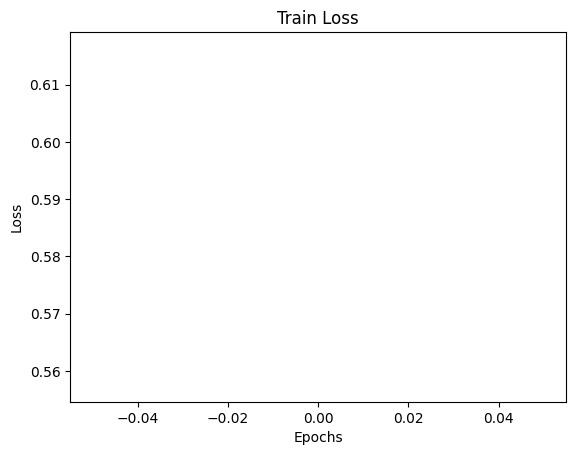

In [33]:
from matplotlib import pyplot as plt
# train the network
vae = AutoEncoder(latent_dim=LATENT_DIM, learning_rate=LEARNING_RATE)
# net = vae.to(get_device())
train_loss = train(vae, train_loader, NUM_EPOCHS, LEARNING_RATE)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_fashionmnist_loss.png')

# test the network
test_image_reconstruction(vae, test_loader)